## Importing Data

In [1]:
import pandas as pd
import numpy as np
import os
import json
import warnings
import seaborn as sns
import matplotlib.pyplot as plt
import pickle

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

Load one file first to see what type of data we're dealing with and what attributes it has

In [2]:
directory = '../data/'

with open(f'{directory}AK_Juneau_0.json') as f:
    jsonfile = json.load(f)

testcity = pd.json_normalize(jsonfile['data']['results']).head(3)

jsoncolumns = testcity.columns

testcity

,last_update_date,tags,permalink,status,list_date,open_houses,branding,list_price,property_id,photos,...,location.address.state_code,location.address.line,location.street_view_url,location.county.fips_code,location.county.name,primary_photo,source,products,location.address.coordinate,other_listings
0,2023-09-19T20:52:50Z,"[carport, community_outdoor_space, cul_de_sac,...",9453-Herbert-Pl_Juneau_AK_99801_M90744-30767,sold,2023-06-29T21:16:25.000000Z,None,"[{'name': 'EXP Realty LLC - Southeast Alaska',...",554950.0,9074430767,"[{'tags': [{'label': 'house_view', 'probabilit...",...,AK,9453 Herbert Pl,https://maps.googleapis.com/maps/api/streetvie...,None,Juneau,NaN,NaN,NaN,NaN,NaN
1,None,None,8477-Thunder-Mountain-Rd_Juneau_AK_99801_M9424...,sold,None,None,"[{'name': None, 'photo': None, 'type': 'Office'}]",NaN,9424983842,None,...,AK,8477 Thunder Mountain Rd,https://maps.googleapis.com/maps/api/streetvie...,None,Juneau,NaN,NaN,NaN,NaN,NaN
2,None,None,4515-Glacier-Hwy_Juneau_AK_99801_M94790-68516,sold,None,None,"[{'name': None, 'photo': None, 'type': 'Office'}]",NaN,9479068516,None,...,AK,4515 Glacier Hwy,https://maps.googleapis.com/maps/api/streetvie...,None,Juneau,NaN,NaN,NaN,NaN,NaN


Make our starting dataframe by looping over all files in our data directory

In [3]:
df = pd.DataFrame(columns= jsoncolumns)

json_files = [file for file in os.listdir(directory) if file.endswith('.json')]

for file in json_files:
    file_path = os.path.join(directory, file)
    json_subfile = pd.read_json(file_path)
    json_subdf = pd.json_normalize(json_subfile['data']['results'])
    with warnings.catch_warnings():
        warnings.simplefilter("ignore")
        df = pd.concat([df, json_subdf], ignore_index=True)
    
df.shape

(8191, 67)

We see we got 3 more columns by looping over all cities - these columns weren't present in our test city.

In [4]:
[col for col in df.columns if col not in jsoncolumns] 

['community.advertisers', 'community.description.name', 'location.county']

## Data Check

How are we doing in terms of nulls?

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8191 entries, 0 to 8190
Data columns (total 67 columns):
 #   Column                                 Non-Null Count  Dtype  
---  ------                                 --------------  -----  
 0   last_update_date                       8125 non-null   object 
 1   tags                                   7638 non-null   object 
 2   permalink                              8159 non-null   object 
 3   status                                 8159 non-null   object 
 4   list_date                              7752 non-null   object 
 5   open_houses                            0 non-null      object 
 6   branding                               8159 non-null   object 
 7   list_price                             7721 non-null   object 
 8   property_id                            8159 non-null   object 
 9   photos                                 7403 non-null   object 
 10  community                              0 non-null      object 
 11  virt

Quick look at our numeric distributions

In [6]:
df.describe()

,price_reduced_amount,description.year_built,description.baths_3qtr,description.baths_full,description.baths_half,description.lot_sqft,description.sqft,description.baths,description.garage,description.stories,description.beds,location.address.coordinate.lon,location.address.coordinate.lat,location.county
count,2.484000e+03,7316.000000,566.000000,7311.000000,2281.000000,6.991000e+03,7323.000000,7980.000000,4448.000000,6260.000000,7504.000000,7909.000000,7909.000000,0.0
mean,2.442704e+04,1968.916074,1.247350,1.887430,1.105655,2.510949e+05,1933.848559,2.131203,1.926709,1.567732,3.208289,-92.206522,39.009689,NaN
std,7.162396e+04,35.096914,0.463482,0.862214,0.413340,5.823820e+06,1339.039206,1.175940,0.878766,0.730969,1.282732,15.888886,4.374553,NaN
min,1.000000e+02,1828.000000,1.000000,1.000000,1.000000,0.000000e+00,120.000000,0.000000,1.000000,1.000000,0.000000,-157.810583,21.277707,NaN
25%,6.000000e+03,1950.000000,1.000000,1.000000,1.000000,4.953000e+03,1258.000000,1.000000,1.000000,1.000000,3.000000,-104.971611,35.688084,NaN
50%,1.010000e+04,1975.000000,1.000000,2.000000,1.000000,7.841000e+03,1635.000000,2.000000,2.000000,1.000000,3.000000,-89.333131,39.698210,NaN
75%,2.000000e+04,1997.000000,1.000000,2.000000,1.000000,1.263200e+04,2264.000000,3.000000,2.000000,2.000000,4.000000,-78.617690,41.832266,NaN
max,2.015999e+06,2024.000000,3.000000,8.000000,5.000000,1.676624e+08,32106.000000,9.000000,11.000000,10.000000,12.000000,-71.006343,58.396178,NaN


Look at a sample row to get an idea of column structure

In [7]:
print(df.iloc[0,0:10])
print(df.iloc[0,10:20])
print(df.iloc[0,20:30])

last_update_date                                 2024-01-17T00:01:55Z
tags                [central_air, dishwasher, fireplace, forced_ai...
permalink             1869-Pebble-Ct_Harrisburg_PA_17110_M33009-59879
status                                                           sold
list_date                                 2023-11-27T05:15:07.000000Z
open_houses                                                      None
branding            [{'name': 'Howard Hanna - Colonial Park', 'pho...
list_price                                                     334900
property_id                                                3300959879
photos              [{'tags': [{'label': 'garage', 'probability': ...
Name: 0, dtype: object
community                                                            None
virtual_tours                                                        None
listing_id                                                     2961973062
price_reduced_amount                                   

In [8]:
print(df.iloc[0,30:40])
print(df.iloc[0,40:50])
print(df.iloc[0,50:60])
print(df.iloc[0,60:70])

description.sub_type                              None
description.baths_1qtr                            None
description.garage                                 2.0
description.stories                                1.0
description.beds                                   3.0
description.type                         single_family
lead_attributes.show_contact_an_agent             True
flags.is_new_construction                         None
flags.is_for_rent                                 None
flags.is_subdivision                              None
Name: 0, dtype: object
flags.is_contingent                                                          None
flags.is_price_reduced                                                       None
flags.is_pending                                                             None
flags.is_foreclosure                                                         None
flags.is_plan                                                                None
flags.is_coming_s

Lets take a look at the complex columns

In [9]:
print(df['tags'][0])

['central_air', 'dishwasher', 'fireplace', 'forced_air', 'hardwood_floors', 'washer_dryer', 'basement', 'single_story', 'garage_1_or_more', 'garage_2_or_more', 'big_yard', 'vaulted_ceiling', 'open_floor_plan', 'floor_plan', 'corner_lot', 'big_lot', 'ensuite']


In [10]:
print(df['branding'][0])

[{'name': 'Howard Hanna - Colonial Park', 'photo': None, 'type': 'Office'}]


In [11]:
print(df['photos'][0]) 

[{'tags': [{'label': 'garage', 'probability': 0.99981635808945}, {'label': 'house_view', 'probability': 0.99869686365128}, {'label': 'road_view', 'probability': 0.99956554174423}, {'label': 'yard', 'probability': 0.9751615524292}, {'label': 'house_view', 'probability': 0.99909782409668}, {'label': 'house_view', 'probability': 0.99994349479675}], 'href': 'https://ap.rdcpix.com/8c0b391ae4f9bbca36c41d559ef75598l-m2349710986s-w1024_h768.jpg'}]


Drop the the columns we initially think we won't encode any useful information - using best judgement here.

Some of these are debateable - theoretically could leave in and employ downstream feature selection

In [12]:

drop_cols = ['last_update_date', 'permalink', 'list_date', 'open_houses', 'branding', 
             'property_id', 'photos', 'community', 'virtual_tours', 'listing_id', 'matterport',
             'primary_photo.href', 'source.plan_id', 'source.agents', 'source.spec_id', 
             'source.type', 'description.name','lead_attributes.show_contact_an_agent',
               'price_reduced_amount', 'flags.is_for_rent', 'flags.is_contingent',
               'flags.is_pending', 'flags.is_plan', 'flags.is_coming_soon', 'flags.is_new_listing',
               'products.brand_name', 'other_listings.rdc', 'location.address.postal_code', 'location.address.line',
               'location.street_view_url', 'location.county.fips_code', 'primary_photo', 'source', 'products',
               'location.address.coordinate', 'other_listings', 'community.advertisers', 'community.description.name',
               'location.county', 'status', 'location.address.state']

df = df.drop(columns= drop_cols)

In [13]:
df.shape

(8191, 26)

price reduced, foreclosure, new construction and subdivision seem like they could be useful, but are they actual present?

In [14]:
df['flags.is_price_reduced'].value_counts()/df.shape[0]

flags.is_price_reduced
False    0.293859
True     0.009401
Name: count, dtype: float64

In [15]:
df['flags.is_foreclosure'].value_counts()/df.shape[0]

flags.is_foreclosure
True    0.005128
Name: count, dtype: float64

In [16]:
df['flags.is_new_construction'].value_counts()/df.shape[0]

Series([], Name: count, dtype: float64)

In [17]:
df['flags.is_subdivision'].value_counts()/df.shape[0]

Series([], Name: count, dtype: float64)

They're all very rare, or null, so lets ditch them too

In [18]:
df = df.drop(columns=['flags.is_price_reduced', 'flags.is_foreclosure', 'flags.is_new_construction', 'flags.is_subdivision'])

What about tags, how many houses dont have tags?

In [19]:
missing_tags = df[df['tags'].isna()]
missing_tags.shape[0]/df.shape[0]

0.06751312416066414

7%, so 93% have at least one tag

Lets unpack each tag into its own column (basically OHE)

In [20]:
# Extract tags
tags = list({tag for sublist in df['tags'] if isinstance(sublist, list) for tag in sublist})

# Dataframe for tags
tag_df = pd.DataFrame(0, index=df.index, columns=tags)

# Fill in tags
for tag in tags:
    tag_df[tag] = df['tags'].apply(lambda x: 1 if isinstance(x, list) and tag in x else 0)

# Concatenate tag df and original feature set
df = pd.concat([df, tag_df], axis=1)

# Drop the original 'tags' column
df.drop('tags', axis=1, inplace=True)


In [21]:
df.shape

(8191, 176)

## Handling Missing Values

Lets drop houses where we're missing a very important piece of info, or missing the target.

Could make an argument for imputing these - but thats a question of data quantity vs quality. Dropping these means we lose data, but if we impute instead, our data will be of lower quality, because we're masking the actual relationships by including imprecise estimates.

In [22]:
df = df[~df['description.sold_price'].isna()] 
df = df[~df['description.type'].isna()] 
df = df[~df['description.year_built'].isna()]
df = df[~df['description.lot_sqft'].isna()]
df = df[~df['description.sqft'].isna()]
df = df[~df['location.address.coordinate.lon'].isna()]
df = df[~df['location.address.coordinate.lat'].isna()]
df.shape

(5260, 176)

First 20 columns

In [23]:
original_features = df.iloc[:,0:21] #full feature set is too big for info()
original_features.info()

<class 'pandas.core.frame.DataFrame'>
Index: 5260 entries, 0 to 8190
Data columns (total 21 columns):
 #   Column                           Non-Null Count  Dtype  
---  ------                           --------------  -----  
 0   list_price                       5210 non-null   object 
 1   description.year_built           5260 non-null   float64
 2   description.baths_3qtr           347 non-null    float64
 3   description.sold_date            5260 non-null   object 
 4   description.sold_price           5260 non-null   object 
 5   description.baths_full           5112 non-null   float64
 6   description.baths_half           1728 non-null   float64
 7   description.lot_sqft             5260 non-null   float64
 8   description.sqft                 5260 non-null   float64
 9   description.baths                5162 non-null   float64
 10  description.sub_type             685 non-null    object 
 11  description.baths_1qtr           0 non-null      object 
 12  description.garage       

In [24]:
# List price is too close to target, assume we don't know it
# 1qtr baths is all null

df = df.drop(columns=['list_price', 'description.baths_1qtr']) 

# the year it was sold might be interesting, but the date is currently a string. Lets make the year an int
df['description.sold_date'] = df['description.sold_date'].str.slice(0, 4).astype(int)

# Assume for these if its null, its just 0
columns_to_fill_zeroes = ['description.baths_3qtr', 'description.baths_full', 'description.baths_half', 'description.baths',
                          'description.garage', 'description.beds']
df[columns_to_fill_zeroes] = df[columns_to_fill_zeroes].fillna(0)

# Fill these with a generic "N/A" category instead of a null
columns_to_fill_NA = ['description.sub_type', 'location.address.city', 'location.county.name']
df[columns_to_fill_NA] = df[columns_to_fill_NA].fillna('N/A')

# If stories is missing, assume its just 1
columns_to_fill_ones = ['description.stories']
df[columns_to_fill_ones] = df[columns_to_fill_ones].fillna(1)


## Handling the Tags

OHEing tags means we have a LOT of columns

In [25]:
df.columns[19:] # tags or tag like start at 19

Index(['medicalcare', 'disability_features', 'hardwood_floors', 'views',
       'greenhouse', 'community_elevator', 'farm', 'well_water',
       'granite_kitchen', 'fixer_upper',
       ...
       'ensuite', 'view', 'cul_de_sac', 'large_porch', 'courtyard_entry',
       'coffer_ceiling', 'equestrian', 'basketball',
       'community_horse_facilities', 'vaulted_ceiling'],
      dtype='object', length=155)

This code prints the proportion where each tag is not-zero. Its quite long

In [26]:
# for column in df.columns[19:]:
#     non_zero_count = df[column].sum()  
#     total_count = len(df)  
#     proportion_non_zero = non_zero_count / total_count  
#     print(f"Column: {column}, Proportion of non-zero values: {proportion_non_zero:.2f}")



Lets drop all of the tags that are less that 5% non-zero

In [27]:
columns_to_drop = []

for column in df.columns[19:]:
    non_zero_count = df[column].sum()  
    total_count = len(df)  
    proportion_non_zero = non_zero_count / total_count  
    if proportion_non_zero < 0.05:
        columns_to_drop.append(column)

df.drop(columns_to_drop, axis=1, inplace=True)

print("Columns dropped:")
print(columns_to_drop)

Columns dropped:
['medicalcare', 'greenhouse', 'community_elevator', 'well_water', 'granite_kitchen', 'private_parking', 'solar_panels', 'marina', 'detached_guest_house', 'game_room', 'media_room', 'golf_course', 'exposed_brick', 'volleyball', 'wrap_around_porch', 'two_master_suites', 'spa_or_hot_tub', 'kitchen_island', 'boat_dock', 'beautiful_backyard', 'solar_system', 'smart_homes', 'theater_room', 'mountain_view', 'master_bathroom', 'rv_or_boat_parking', 'tennis', 'library', 'community_gym', 'greenbelt', 'dual_master_bedroom', 'master_suite', 'ocean_view', 'beach', 'pets_allowed', 'horse_facilities', 'river_access', 'hoa', 'open_house', 'white_kitchen', 'open_kitchen', 'horse_stables', 'community_park', 'security', 'community_golf', 'pond', 'fenced_courtyard', 'furniture', 'efficient', 'jack_and_jill_bathroom', 'guest_house', 'soccer', 'private_courtyard', 'waterfront', 'community_boat_facilities', 'maintenance', 'hill_or_mountain_view', 'horse_property', 'guest_parking', 'two_kitch

In [28]:
len(columns_to_drop)

106

68 Columns is much more reasonable for now

In [29]:
df.shape

(5260, 68)

Type still needs to be OHE'd

In [30]:
df['description.type'] = df['description.type'].replace('condo', 'condos')
df = pd.get_dummies(df, columns=['description.type', 'description.sub_type'])

In [31]:
df.shape

(5260, 76)

## Handling Cities/Counties/States

In [32]:
train_df, test_df = train_test_split(df, test_size= 0.2, random_state= 42)

Approach: Compute the mean of sold price by city, and state.
- Note that we could just do city 
- We'll ignore county because there is usually only 1-2 major cities per county

Compute on training data, then join to both

In [33]:
train_df, test_df = train_df.drop(columns = ['location.county.name']), test_df.drop(columns = ['location.county.name'])

In [34]:
city_mean_df = train_df.groupby('location.address.city')['description.sold_price'].mean()
state_mean_df = train_df.groupby('location.address.state_code')['description.sold_price'].mean()

train_df = train_df.merge(city_mean_df, left_on='location.address.city', right_index=True, how='left', suffixes=('', '_city_mean'))
test_df = test_df.merge(city_mean_df, left_on='location.address.city', right_index=True, how='left', suffixes=('', '_city_mean'))

train_df = train_df.merge(state_mean_df, left_on='location.address.state_code', right_index=True, how='left', suffixes=('', '_state_mean'))
test_df = test_df.merge(state_mean_df, left_on='location.address.state_code', right_index=True, how='left', suffixes=('', '_state_mean'))

train_df['description.sold_price_city_mean'] = train_df['description.sold_price_city_mean'].astype(float)
train_df['description.sold_price_state_mean'] = train_df['description.sold_price_city_mean'].astype(float)
test_df['description.sold_price_city_mean'] = test_df['description.sold_price_city_mean'].astype(float)
test_df['description.sold_price_state_mean'] = test_df['description.sold_price_city_mean'].astype(float)


In [35]:
# We need the cities as a column when we save this
# We also need the columns to be named the same
city_mean_df = city_mean_df.reset_index().rename(columns={"description.sold_price": "description.sold_price_city_mean"}) 

In [36]:
print("NAs in train state?", train_df['description.sold_price_state_mean'].isna().any())
print("NAs in train city?", train_df['description.sold_price_city_mean'].isna().any())

print("NAs in test state?", test_df['description.sold_price_state_mean'].isna().any())
print("NAs in test city?", test_df['description.sold_price_city_mean'].isna().any())


NAs in train state? False
NAs in train city? False
NAs in test state? True
NAs in test city? True


There are some NAs where a city ended up in the test fold but not training. We'll impute the global mean in this case. We'll do the same for state as well (this wont do anything, but other data could theoretically have a missing state, so lets be thorough in our process)

In [37]:
pd.set_option('future.no_silent_downcasting', True)

In [38]:
global_mean_city = train_df['description.sold_price'].mean()
train_df['description.sold_price_city_mean'] = train_df['description.sold_price_city_mean'].fillna(global_mean_city)
test_df['description.sold_price_city_mean'] = test_df['description.sold_price_city_mean'].fillna(global_mean_city)

global_mean_state = train_df['description.sold_price_state_mean'].mean()
train_df['description.sold_price_state_mean'] = train_df['description.sold_price_state_mean'].fillna(global_mean_state)
test_df['description.sold_price_state_mean'] = test_df['description.sold_price_state_mean'].fillna(global_mean_state)

In [39]:
train_df.shape

(4208, 77)

In [40]:
test_df.shape

(1052, 77)

## EDA

In [41]:
cols_to_int = ['description.year_built', 'description.baths_3qtr', 'description.baths_full', 'description.baths_half',
               'description.lot_sqft', 'description.sqft', 'description.baths', 'description.garage', 'description.stories',
               'description.beds', 'description.sold_price']
train_df[cols_to_int] = train_df[cols_to_int].astype(int)
test_df[cols_to_int] = test_df[cols_to_int].astype(int)


Column: disability_features, Proportion: 0.05
Column: hardwood_floors, Proportion: 0.36
Column: views, Proportion: 0.05
Column: farm, Proportion: 0.09
Column: fixer_upper, Proportion: 0.05
Column: fenced_yard, Proportion: 0.17
Column: family_room, Proportion: 0.18
Column: washer_dryer, Proportion: 0.3
Column: dishwasher, Proportion: 0.49
Column: garage_2_or_more, Proportion: 0.44
Column: garage_1_or_more, Proportion: 0.64
Column: ranch, Proportion: 0.09
Column: corner_lot, Proportion: 0.09
Column: rental_property, Proportion: 0.1
Column: community_security_features, Proportion: 0.22
Column: garage_3_or_more, Proportion: 0.07
Column: big_lot, Proportion: 0.11
Column: fireplace, Proportion: 0.48
Column: floor_plan, Proportion: 0.13
Column: carport, Proportion: 0.07
Column: central_air, Proportion: 0.56
Column: groundscare, Proportion: 0.06
Column: central_heat, Proportion: 0.19
Column: recreation_facilities, Proportion: 0.21
Column: community_outdoor_space, Proportion: 0.52
Column: commu

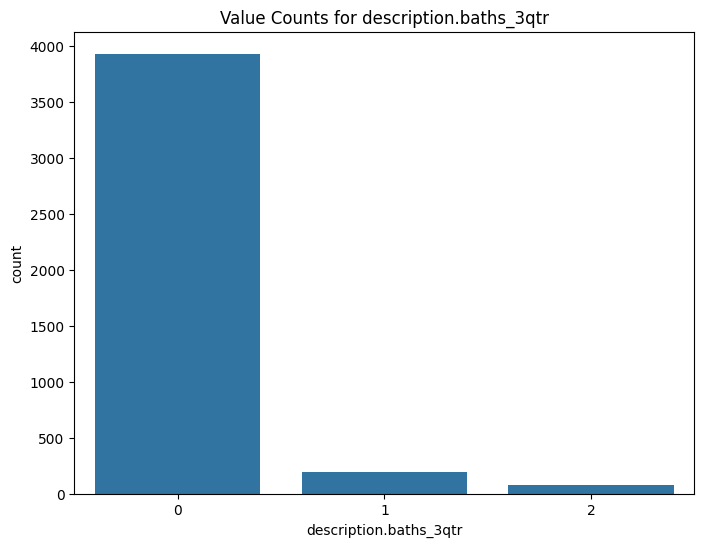

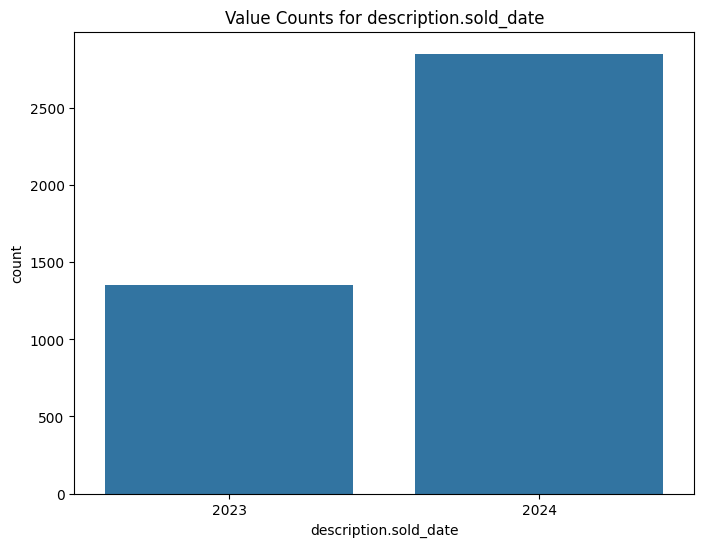

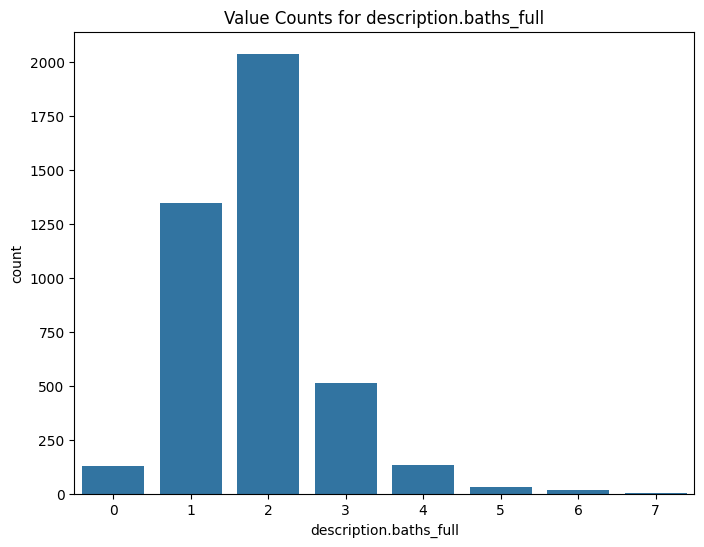

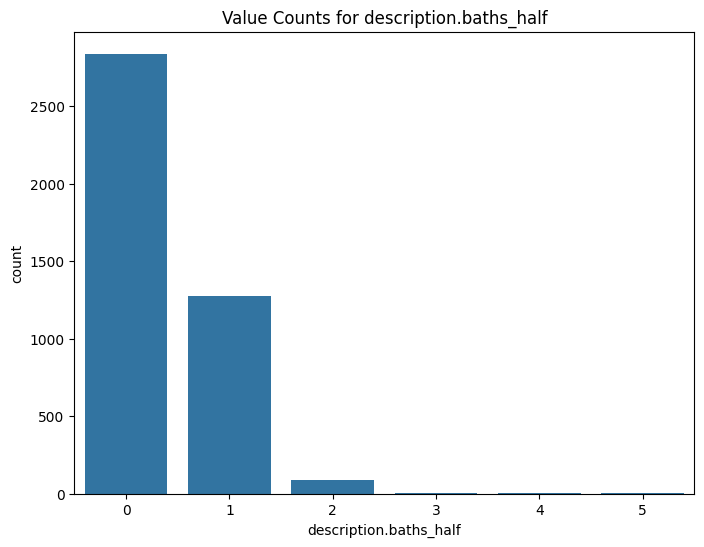

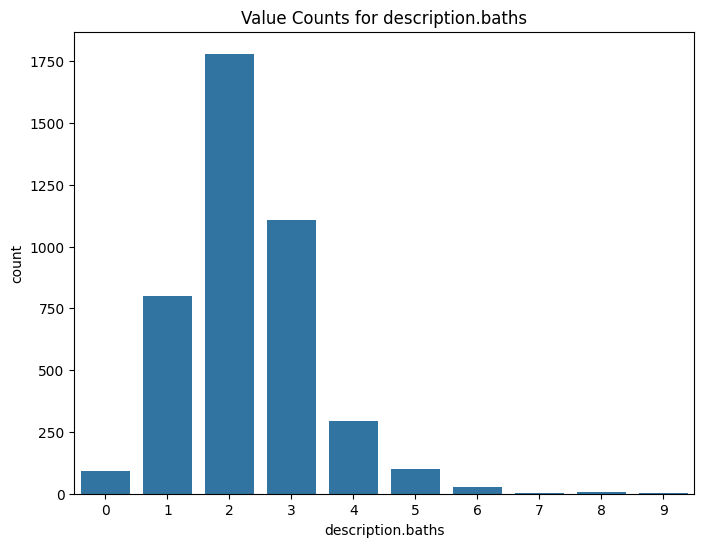

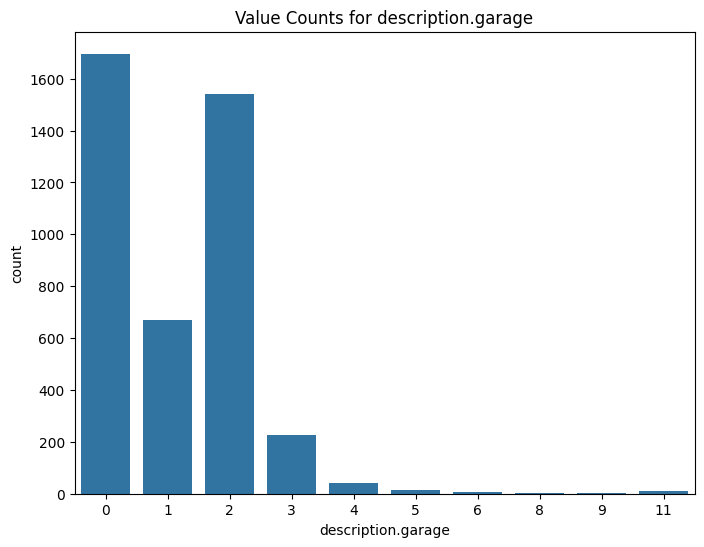

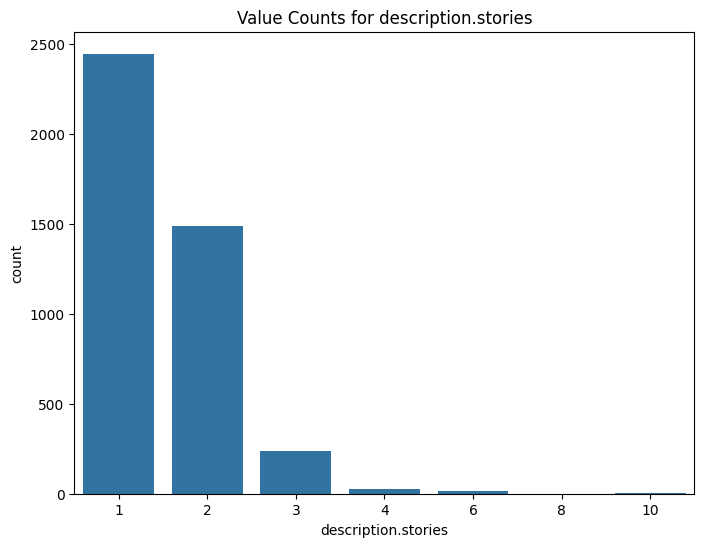

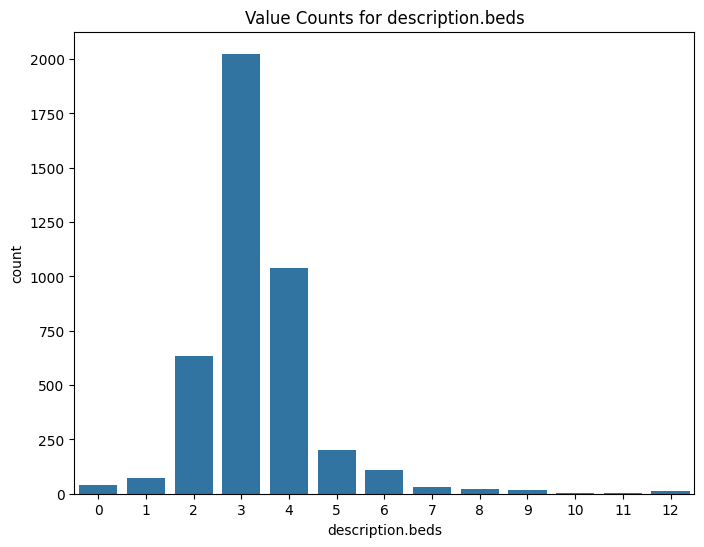

In [42]:
# group our columns based on their datatypes
int_columns = [col for col in train_df.columns if train_df[col].dtype == int]
hist_columns = ['description.year_built', 'description.sold_price', 'description.lot_sqft', 'description.sqft']
binary_columns = [col for col in int_columns if train_df[col].max() == 1]
int_columns = [col for col in int_columns if col not in hist_columns and col not in binary_columns]
float_cols = [col for col in train_df.columns if train_df[col].dtype == float]

# histograms for continuous
for col in float_cols:
    hist_columns.append(col)

# Show the proportion only for binary
for col in binary_columns:
    print(f"Column: {col}, Proportion: {round(train_df[col].sum()/len(train_df),2)}")

# Countplot for discrete
for col in int_columns:
    plt.figure(figsize=(8, 6))
    sns.countplot(data=train_df, x=col)
    plt.title(f'Value Counts for {col}')
    plt.show()

In [43]:
hist_columns

['description.year_built',
 'description.sold_price',
 'description.lot_sqft',
 'description.sqft',
 'location.address.coordinate.lon',
 'location.address.coordinate.lat',
 'description.sold_price_city_mean',
 'description.sold_price_state_mean']

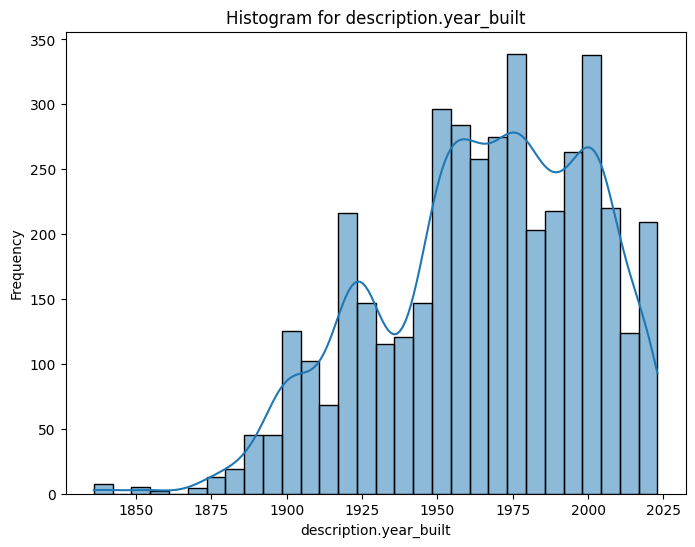

In [44]:
plt.figure(figsize=(8, 6))
sns.histplot(data=train_df, x='description.year_built', kde=True)
plt.title(f'Histogram for description.year_built')
plt.ylabel('Frequency')
plt.show()

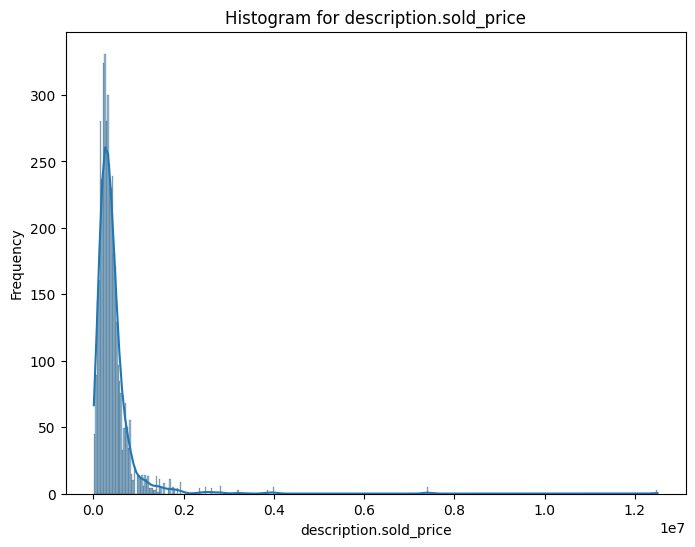

In [45]:
plt.figure(figsize=(8, 6))
sns.histplot(data=train_df, x='description.sold_price', kde=True)
plt.title(f'Histogram for description.sold_price')
plt.ylabel('Frequency')
plt.show()

This is our target, and its VERY right skewed. Lets log transform it for stability/ so large values don't dominate

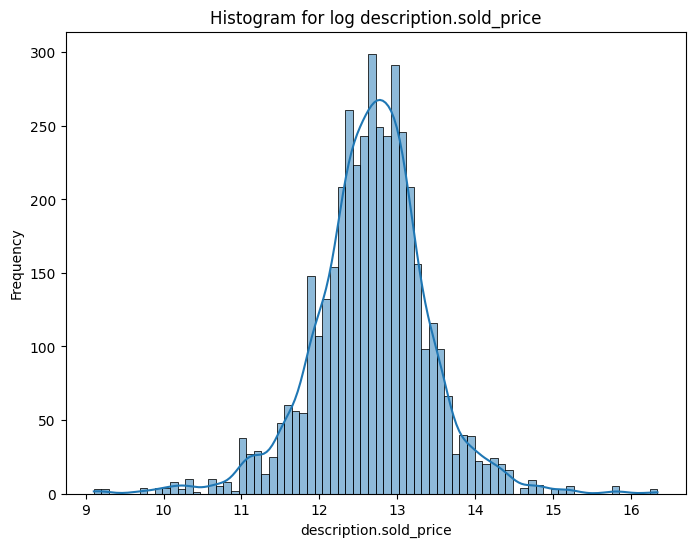

In [46]:
train_df['description.sold_price'] = np.log(train_df['description.sold_price'])
test_df['description.sold_price'] = np.log(test_df['description.sold_price'])
plt.figure(figsize=(8, 6))
sns.histplot(data=train_df, x= 'description.sold_price', kde=True)
plt.title(f'Histogram for log description.sold_price')
plt.ylabel('Frequency')
plt.show()

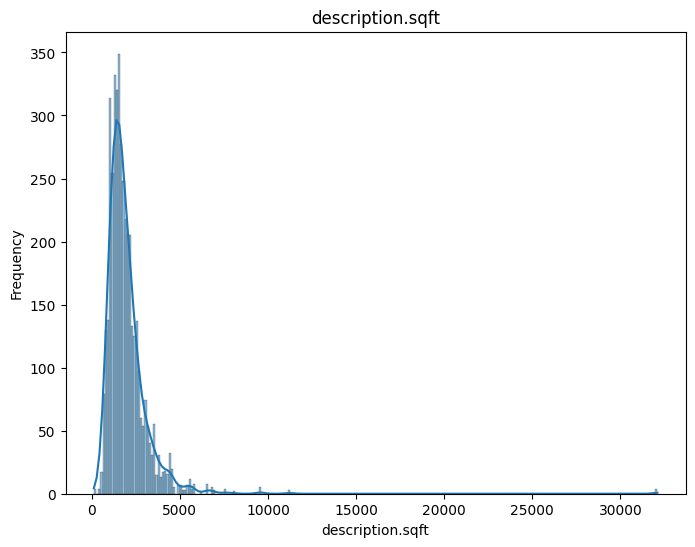

In [47]:
plt.figure(figsize=(8, 6))
sns.histplot(data=train_df, x='description.sqft', kde=True)
plt.title(f'description.sqft')
plt.ylabel('Frequency')
plt.show()

Lets log sqft as well

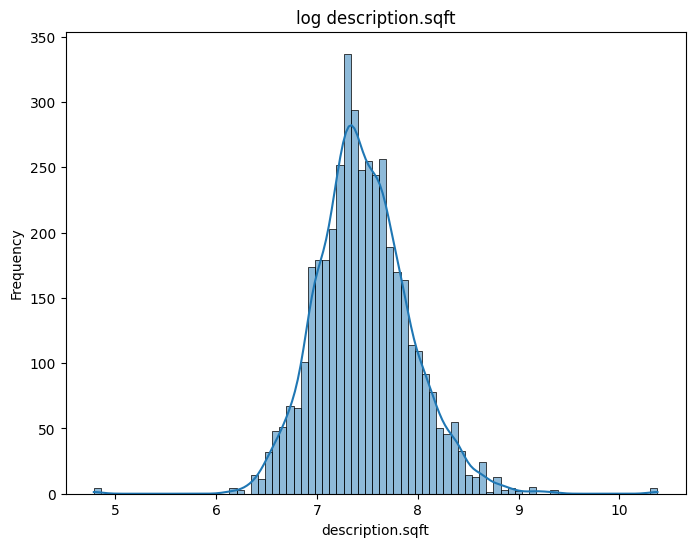

In [48]:
train_df['description.sqft'] = np.log(train_df['description.sqft'])
test_df['description.sqft'] = np.log(test_df['description.sqft'])
plt.figure(figsize=(8, 6))
sns.histplot(data=train_df, x='description.sqft', kde=True)
plt.title(f'log description.sqft')
plt.ylabel('Frequency')
plt.show()

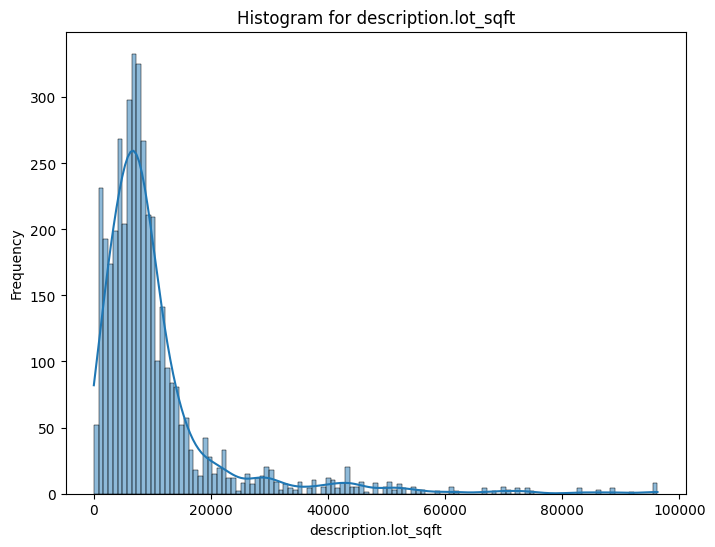

In [49]:
filtered_data = train_df[train_df['description.lot_sqft'] <= 1e5]
plt.figure(figsize=(8, 6))
sns.histplot(data=filtered_data, x='description.lot_sqft', kde=True)
plt.title(f'Histogram for description.lot_sqft')
plt.ylabel('Frequency')
plt.show()

And lot sqft

/opt/miniconda3/lib/python3.10/site-packages/pandas/core/arraylike.py:399: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


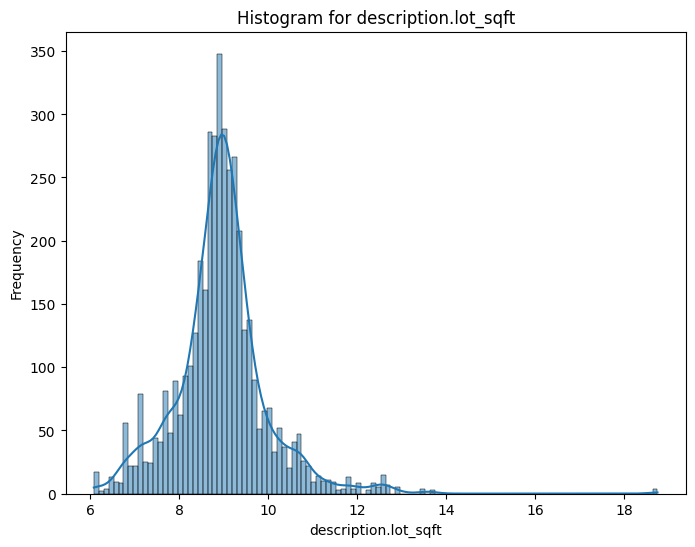

In [50]:
train_df['description.lot_sqft'] = np.log(train_df['description.lot_sqft'])
test_df['description.lot_sqft'] = np.log(test_df['description.lot_sqft'])

plt.figure(figsize=(8, 6))
sns.histplot(data=train_df, x='description.lot_sqft', kde=True)
plt.title(f'Histogram for description.lot_sqft')
plt.ylabel('Frequency')
plt.show()

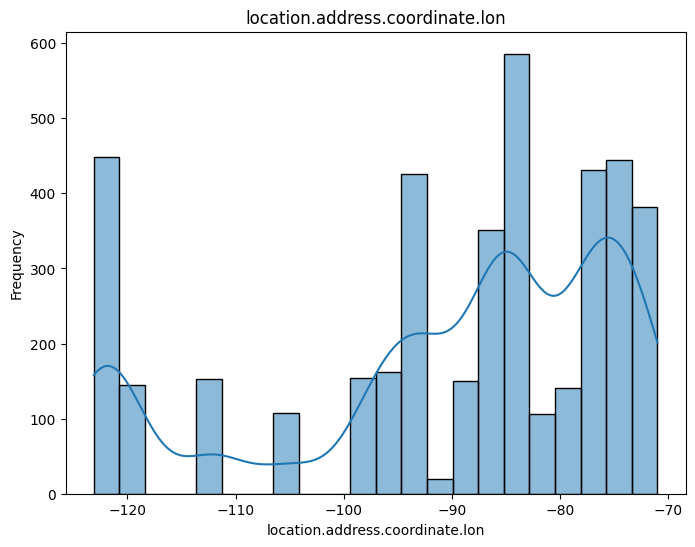

In [51]:
plt.figure(figsize=(8, 6))
sns.histplot(data=train_df, x='location.address.coordinate.lon', kde=True)
plt.title(f'location.address.coordinate.lon')
plt.ylabel('Frequency')
plt.show()

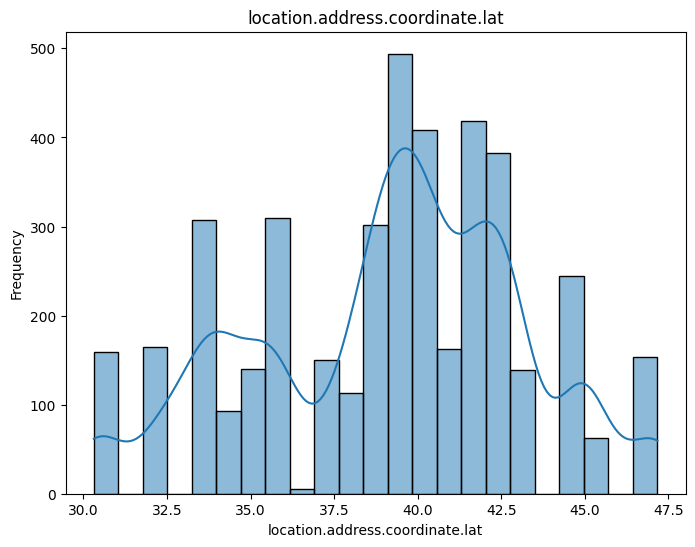

In [52]:
plt.figure(figsize=(8, 6))
sns.histplot(data=train_df, x='location.address.coordinate.lat', kde=True)
plt.title(f'location.address.coordinate.lat')
plt.ylabel('Frequency')
plt.show()

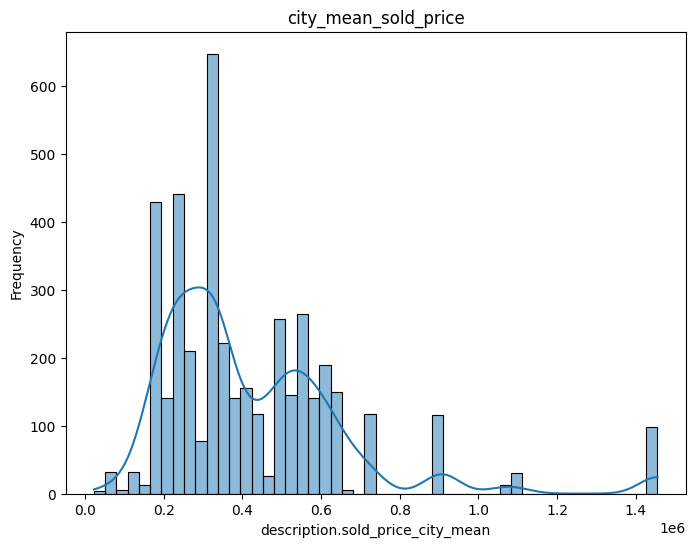

In [53]:
plt.figure(figsize=(8, 6))
sns.histplot(data=train_df, x='description.sold_price_city_mean', kde=True, bins = 50)
plt.title(f'city_mean_sold_price')
plt.ylabel('Frequency')
plt.show()

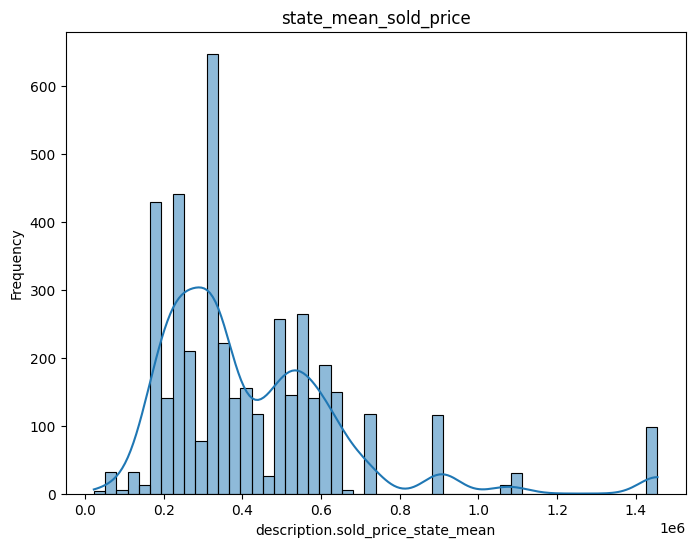

In [54]:
plt.figure(figsize=(8, 6))
sns.histplot(data=train_df, x='description.sold_price_state_mean', kde=True, bins = 50)
plt.title(f'state_mean_sold_price')
plt.ylabel('Frequency')
plt.show()

#### Distributions vs Target

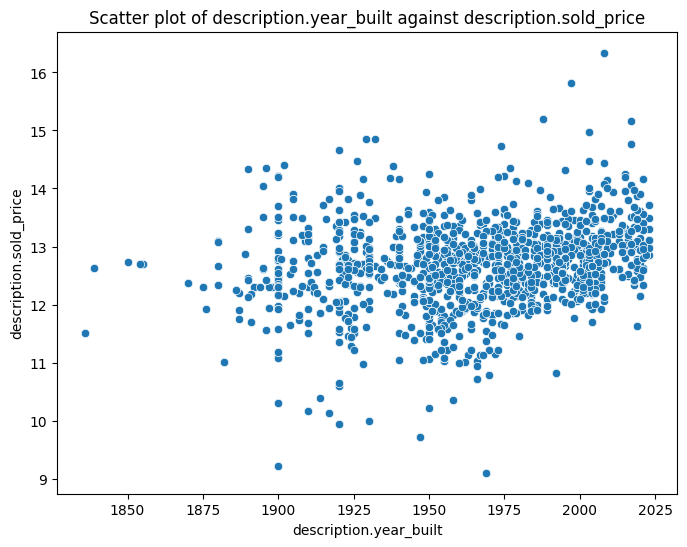

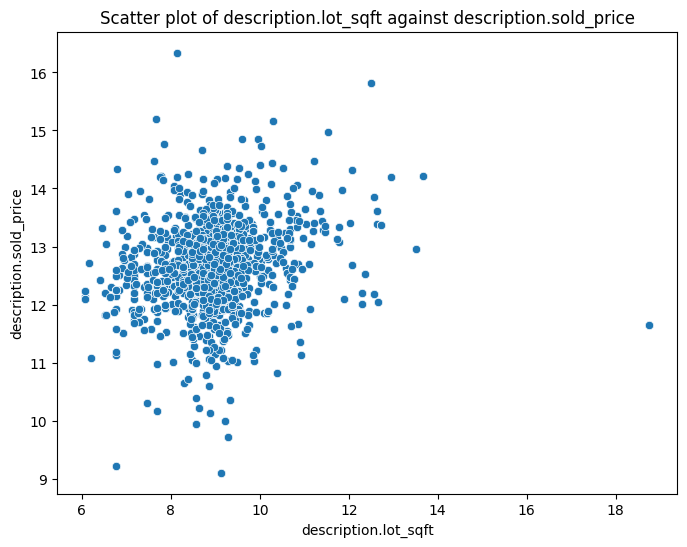

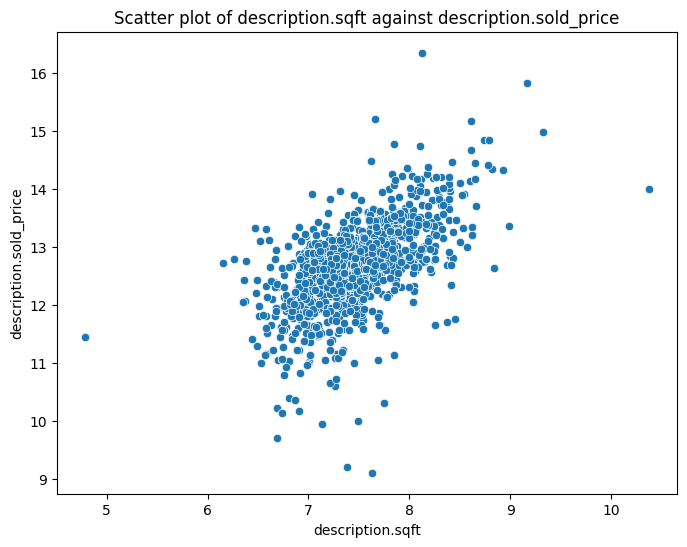

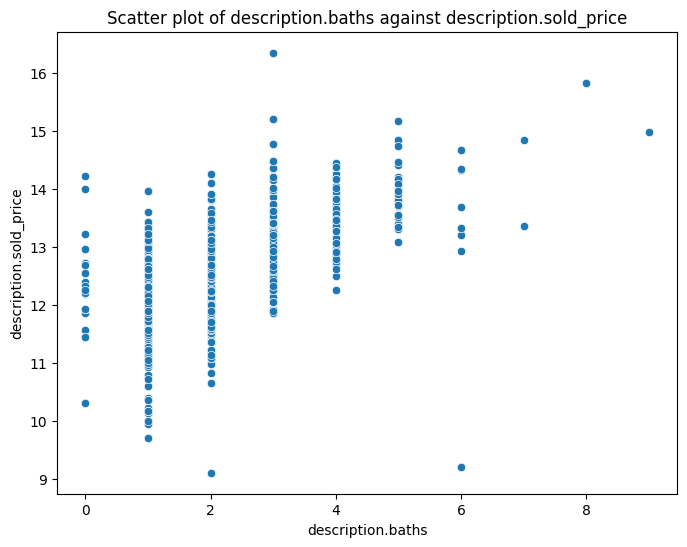

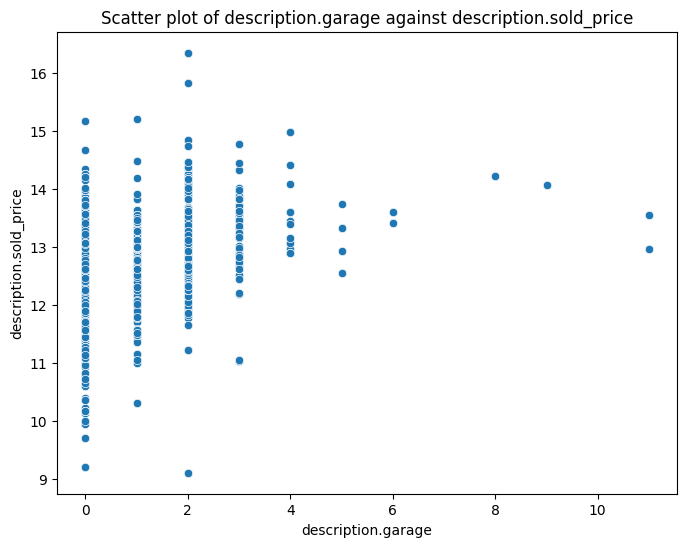

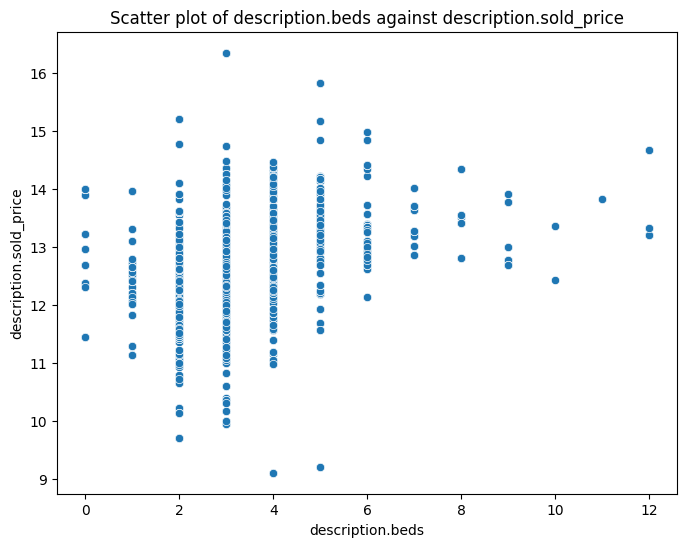

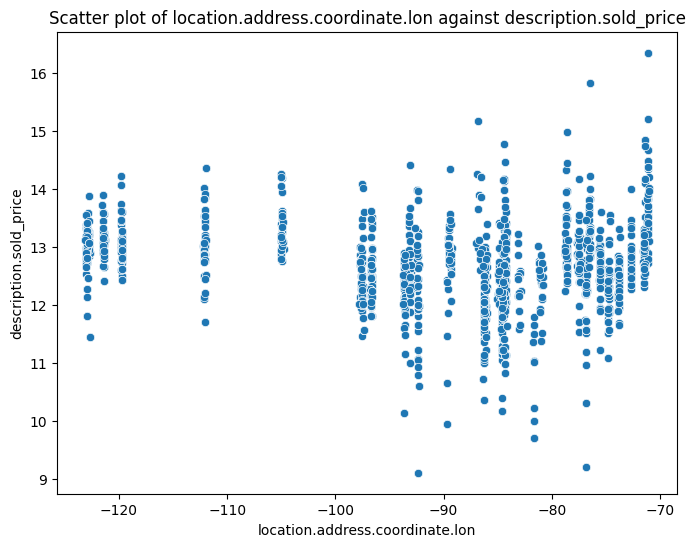

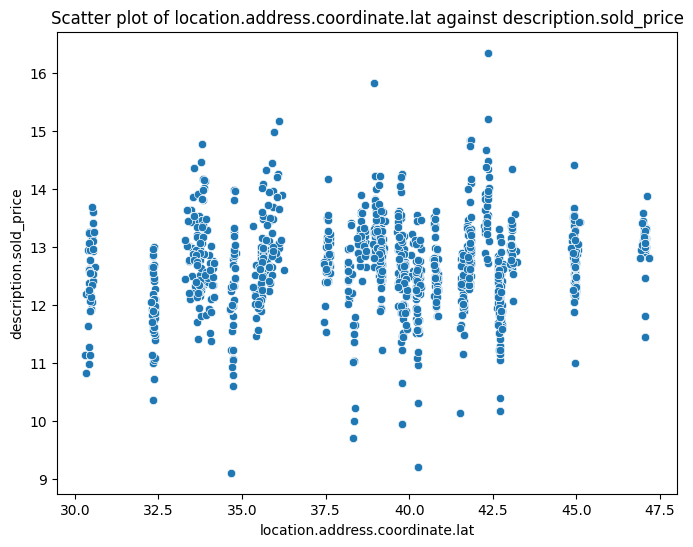

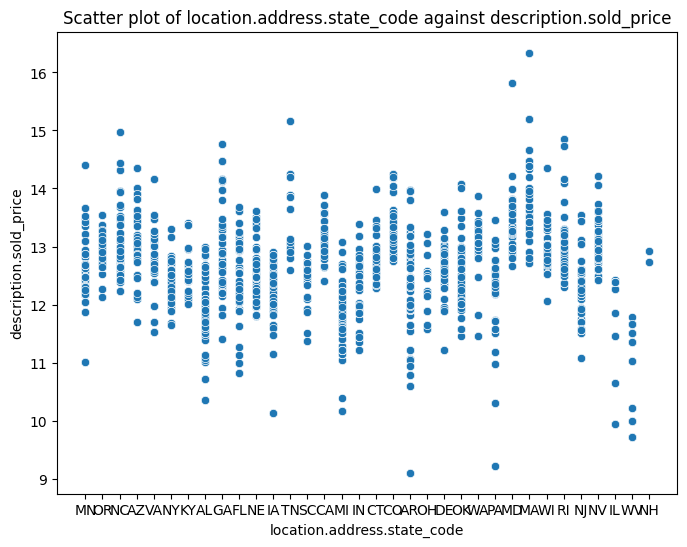

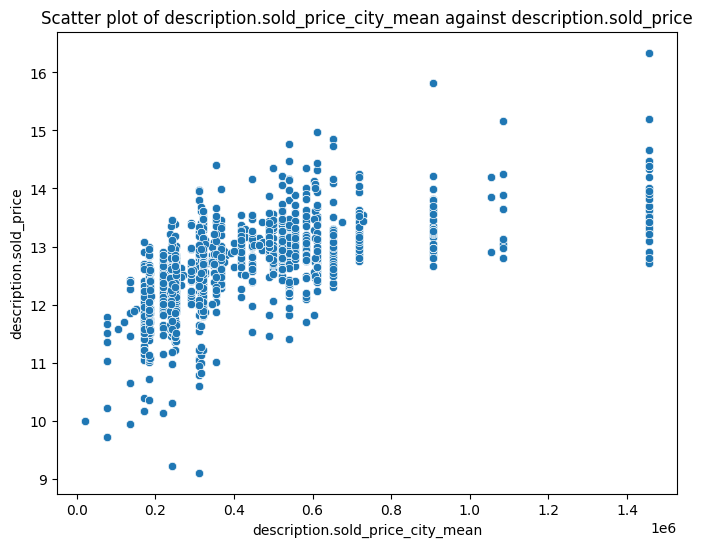

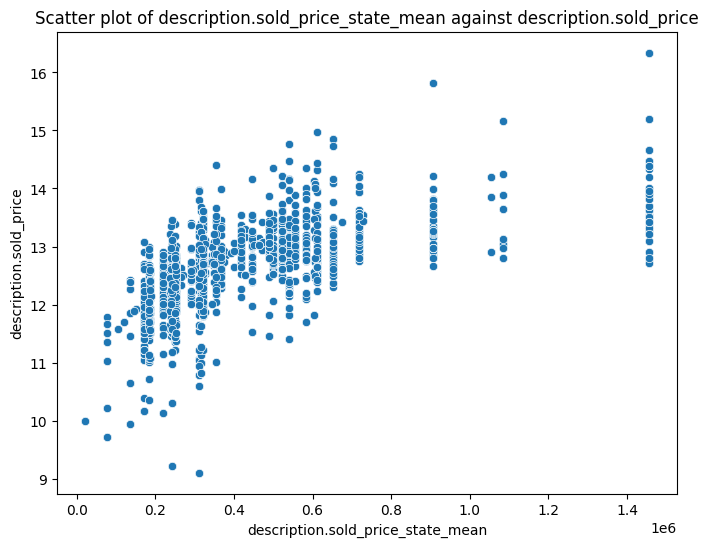

In [55]:
spread_cols = [col for col in train_df.columns if train_df[col].nunique() >= 10]
spread_cols.remove('description.sold_price')
spread_cols.remove('location.address.city')

for col in spread_cols:
    plt.figure(figsize=(8, 6))
    sns.scatterplot(data=train_df, x=col, y='description.sold_price')
    plt.title(f'Scatter plot of {col} against description.sold_price')
    plt.xlabel(col)
    plt.ylabel('description.sold_price')
    plt.show()

Cleaning up remaining string columns

In [56]:
[col for col in train_df.columns if train_df[col].dtype == 'object']

['location.address.city', 'location.address.state_code']

I found these during scaling, but I need to drop them here before we save the cities list so indexes line up

In [57]:
train_df = train_df[train_df['description.lot_sqft'] != -np.inf]
test_df = test_df[test_df['description.lot_sqft'] != -np.inf]

In [58]:
cities = train_df['location.address.city'] # we're going to need this later before we drop it

drop_cols = ['location.address.city', 'location.address.state_code']
train_df, test_df = train_df.drop(columns = drop_cols), test_df.drop(columns = drop_cols)

Lets check for highly colinear features

In [59]:
pairwise_correlations = {}

columns_to_correlate = train_df.columns.to_list()
columns_to_correlate.remove('description.sold_price')

# Compute pairwise correlations
for i in range(len(columns_to_correlate)):
    col1 = columns_to_correlate[i]
    for j in range(i + 1, len(columns_to_correlate)):
        col2 = columns_to_correlate[j]
        correlation = train_df[col1].corr(train_df[col2])
        pairwise_correlations[(col1, col2)] = correlation

/opt/miniconda3/lib/python3.10/site-packages/numpy/lib/function_base.py:2829: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]
/opt/miniconda3/lib/python3.10/site-packages/numpy/lib/function_base.py:2830: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[None, :]


In [60]:
high_corr = {}
for key in pairwise_correlations.keys():
    if np.abs(pairwise_correlations[key]) >= 0.7:
        high_corr[key] = pairwise_correlations[key]

In [61]:
high_corr

{('description.baths_full', 'description.baths'): 0.8130102537103727,
 ('description.garage', 'garage_2_or_more'): 0.8152830160541719,
 ('description.garage', 'garage_1_or_more'): 0.7168879566280958,
 ('description.stories', 'two_or_more_stories'): 0.7729144753617145,
 ('farm', 'ranch'): 0.9500797739142676,
 ('floor_plan', 'open_floor_plan'): 0.7186487142385308,
 ('single_story', 'two_or_more_stories'): -0.7667243887996494,
 ('description.type_condos', 'description.sub_type_condo'): 0.9404785504549078,
 ('description.type_single_family',
  'description.sub_type_N/A'): 0.7243903112017445,
 ('description.type_townhomes',
  'description.sub_type_N/A'): -0.7897004810913449,
 ('description.type_townhomes',
  'description.sub_type_townhouse'): 0.9999999999999998,
 ('description.sub_type_N/A',
  'description.sub_type_townhouse'): -0.7897004810913449,
 ('description.sold_price_city_mean',
  'description.sold_price_state_mean'): 0.9999999999999999}

Of these highly correlated columns, lets remove the ones that appear least useful. 

Incidentally, it seems like we don't need to encode state, its fully correlated with city!

In [62]:
drop_cols = ['description.baths_full', 'garage_1_or_more', 'garage_2_or_more', 'two_or_more_stories',
              'single_story', 'floor_plan', 'description.sub_type_condo', 'description.sub_type_townhouse', 'ranch', 'description.sold_price_state_mean', 'description.sub_type_N/A']

train_df, test_df = train_df.drop(columns = drop_cols), test_df.drop(columns = drop_cols)

Check again to make sure we didn't miss anything

In [63]:
columns_to_correlate = train_df.columns.to_list()
columns_to_correlate.remove('description.sold_price')

pairwise_correlations = {}

for i in range(len(columns_to_correlate)):
    col1 = columns_to_correlate[i]
    for j in range(i + 1, len(columns_to_correlate)):
        col2 = columns_to_correlate[j]
        correlation = train_df[col1].corr(train_df[col2])
        if np.abs(correlation) >= 0.7:
            pairwise_correlations[(col1, col2)] = correlation

pairwise_correlations


/opt/miniconda3/lib/python3.10/site-packages/numpy/lib/function_base.py:2829: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]
/opt/miniconda3/lib/python3.10/site-packages/numpy/lib/function_base.py:2830: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[None, :]


{}

Where are we at for columns now?

In [64]:
train_df.shape

(4204, 64)

## Finishing Up and Saving

Now is a great time to scale the data and save it once it's preprocessed.

In [65]:
# also save mean city price df for reference later

print(train_df.dtypes.value_counts())

X_train = train_df.drop(columns = 'description.sold_price')
y_train = train_df['description.sold_price']

X_test = test_df.drop(columns = 'description.sold_price')
y_test = test_df['description.sold_price']

scaler = StandardScaler() # could test multiple approaches here, but we'll try this

X_train = pd.DataFrame(scaler.fit_transform(X_train), columns = X_train.columns) # maintain column names
X_test = pd.DataFrame(scaler.transform(X_test), columns = X_test.columns)

with open('../models/scaler.pkl', 'wb') as f:
    pickle.dump(scaler, f) # save scaler for later

int64      51
bool        7
float64     6
Name: count, dtype: int64


In [66]:
X_test.columns

Index(['description.year_built', 'description.baths_3qtr',
       'description.sold_date', 'description.baths_half',
       'description.lot_sqft', 'description.sqft', 'description.baths',
       'description.garage', 'description.stories', 'description.beds',
       'location.address.coordinate.lon', 'location.address.coordinate.lat',
       'disability_features', 'hardwood_floors', 'views', 'farm',
       'fixer_upper', 'fenced_yard', 'family_room', 'washer_dryer',
       'dishwasher', 'corner_lot', 'rental_property',
       'community_security_features', 'garage_3_or_more', 'big_lot',
       'fireplace', 'carport', 'central_air', 'groundscare', 'central_heat',
       'recreation_facilities', 'community_outdoor_space',
       'community_swimming_pool', 'basement', 'updated_kitchen', 'big_yard',
       'park', 'new_roof', 'front_porch', 'forced_air', 'dining_room',
       'energy_efficient', 'city_view', 'modern_kitchen', 'high_ceiling',
       'master_bedroom', 'laundry_room', 'open_

In [67]:
X_train.shape

(4204, 63)

In [68]:
X_train.to_csv('../data/processed/X_train.csv', index=False)
X_test.to_csv('../data/processed/X_test.csv', index=False)
y_test.to_csv('../data/processed/y_test.csv', index=False)
y_train.to_csv('../data/processed/y_train.csv', index=False)
city_mean_df.to_csv('../data/processed/city_means.csv', index=False)
cities.to_csv('../data/processed/cities.csv', index=False)